# Human Player Test for ASCII Map Environment

This notebook demonstrates how to use the human player with the new ASCII map-based environment generation.


In [ ]:
import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf

# sorrel imports
from sorrel.examples.staghunt.agents_v2 import StagHuntAgent
from sorrel.examples.staghunt.entities import Empty, entity_list
from sorrel.examples.staghunt.env import StagHuntEnv
from sorrel.examples.staghunt.world import StagHuntWorld
from sorrel.action.action_spec import ActionSpec
from sorrel.models.human_player import HumanPlayer, HumanObservation

In [ ]:
%load_ext autoreload
%autoreload 2

### Human player test for ASCII map environment


In [ ]:
def main():
    # Load ASCII map configuration
    config = OmegaConf.load("../configs/config_ascii_map.yaml")

    # Create world with ASCII map generation
    world = StagHuntWorld(config=config, default_entity=Empty())
    experiment = StagHuntEnv(world, config)

    print(f"World dimensions: {world.height}x{world.width}")
    print(f"Number of agents: {len(experiment.agents)}")
    print(f"Agent spawn points: {len(world.agent_spawn_points)}")

    # Create observation spec with dynamic dimensions
    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,
        env_dims=(world.height, world.width),  # Use actual world dimensions
    )

    # Create action spec for StagHunt environment
    action_spec = ActionSpec(
        [
            "NOOP",
            "FORWARD",
            "BACKWARD",
            "STEP_LEFT",
            "STEP_RIGHT",
            "TURN_LEFT",
            "TURN_RIGHT",
            "INTERACT",
        ]
    )

    # Create a custom HumanPlayer that works with StagHuntAgent
    class StagHuntHumanPlayer(HumanPlayer):
        def __init__(self, input_size, action_space, memory_size):
            super().__init__(input_size, action_space, memory_size)
            # Calculate the expected visual size (without extra features)
            self.visual_size = (
                input_size[0]
                * input_size[1]
                * input_size[2]
                * (self.tile_size**2)
                * self.num_channels
            )
            # The StagHuntAgent will provide visual_size + 3 extra features
            self.total_input_size = self.visual_size + 3

        def take_action(self, state: np.ndarray):
            """Custom take_action that handles StagHuntAgent's extra features."""
            if self.show:
                from IPython.display import clear_output

                clear_output(wait=True)

                # FIXED: Use proper composited visualization instead of separate layers
                from sorrel.utils.visualization import render_sprite, image_from_array
                import matplotlib.pyplot as plt

                # Render the world properly with all layers
                layers = render_sprite(self.world, tile_size=[32, 32])

                # Composite the layers properly to avoid "three rows of walls" effect
                composited = image_from_array(layers)
                composited_array = np.array(composited)
                print(composited_array.shape)

                # Display the composited result
                plt.figure(figsize=(10, 10))
                plt.imshow(composited_array)
                plt.title("Stag Hunt Environment (Fixed Visualization)")
                plt.xlabel("X coordinate")
                plt.ylabel("Y coordinate")
                plt.show()

            # Get action from user with StagHunt-specific controls
            action = None
            num_retries = 0
            while not isinstance(action, int):
                action_ = input(
                    "Select Action (w=FORWARD, s=BACKWARD, a=TURN_LEFT, d=TURN_RIGHT, q=STEP_LEFT, e=STEP_RIGHT, space=INTERACT, 0=NOOP): "
                )
                if action_ in ["w", "s", "a", "d", "q", "e", " "]:
                    if action_ == "w":
                        action = 1  # FORWARD (relative to orientation)
                    elif action_ == "s":
                        action = 2  # BACKWARD (relative to orientation)
                    elif action_ == "a":
                        action = 5  # TURN_LEFT
                    elif action_ == "d":
                        action = 6  # TURN_RIGHT
                    elif action_ == "q":
                        action = 3  # STEP_LEFT
                    elif action_ == "e":
                        action = 4  # STEP_RIGHT
                    elif action_ == " ":
                        action = 7  # INTERACT
                elif action_ in [str(act) for act in self.action_list]:
                    action = int(action_)
                elif action_ == "0":
                    action = 0  # NOOP
                elif action_ == "quit":
                    raise KeyboardInterrupt("Quitting...")
                else:
                    num_retries += 1
                    if num_retries > 5:
                        raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                    print("Please try again. Possible actions are below.")
                    print(
                        "Keys: w=FORWARD, s=BACKWARD, a=TURN_LEFT, d=TURN_RIGHT, q=STEP_LEFT, e=STEP_RIGHT, space=INTERACT, 0=NOOP"
                    )
                    print("Or enter action number (0-7) or 'quit'")

            return action

    # Create a custom StagHuntAgent that bypasses the memory stacking issue
    class StagHuntHumanAgent(StagHuntAgent):
        def get_action(self, state: np.ndarray) -> int:
            """Override get_action to bypass memory stacking for human player."""
            # For human player, we don't need memory stacking
            # Just pass the state directly to the model
            action = self.model.take_action(state)
            return action

        def add_memory(
            self, state: np.ndarray, action: int, reward: float, done: bool
        ) -> None:
            """Override add_memory to handle dimension mismatch for human player."""
            # For human player, we don't need to store experiences in memory
            # The human player doesn't learn from experience, so we can skip this
            pass

    # Create human player with dynamic dimensions
    human_player = StagHuntHumanPlayer(
        input_size=(
            world.height,
            world.width,
            3,  # 3 layers: terrain, dynamic, beam
        ),
        action_space=action_spec.n_actions,
        memory_size=1,
    )

    # Create human agent
    human_agent = StagHuntHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player,
    )

    # Replace all agents with human agent for single-player mode
    experiment.override_agents(agents=[human_agent])

    print("\nStarting human player game with ASCII map environment...")
    print("Controls:")
    print("  w = FORWARD, s = BACKWARD")
    print("  a = TURN_LEFT, d = TURN_RIGHT")
    print("  q = STEP_LEFT, e = STEP_RIGHT")
    print("  space = INTERACT, 0 = NOOP")
    print("  quit = Exit game")
    print("\nPress Enter to start...")
    input()

    experiment.run_experiment()

### Run the human player game


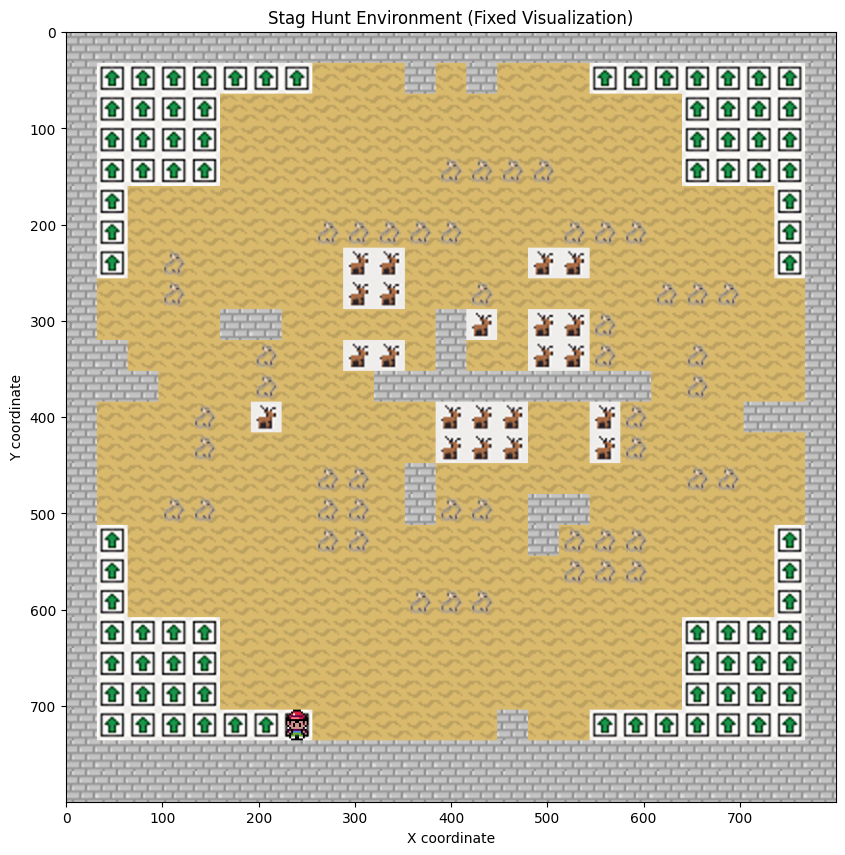

KeyboardInterrupt: Quitting...

In [12]:
main()